In [1]:
%run setup.ipynb

In [2]:
callset = phase2_ar1.callset_pass_biallelic
# g3R = allel.GenotypeChunkedArray(callset['3R']['calldata']['genotype'])
# g3L = allel.GenotypeChunkedArray(callset['3L']['calldata']['genotype'])
df_samples = phase2_ar1.df_samples
df_samples.reset_index(inplace=True)
populations = phase2_ar1.pop_ids
pop_labels = phase2_ar1.pop_labels
#make idx dict for subpops
idx_dic = {p : list(df_samples[df_samples.population == p].index) for p in populations}

In [3]:
region_3R_free = '3R-free', '3R', 1, 37000000
region_3L_free = '3L-free', '3L', 15000000, 41000000

In [4]:
# ac_3R = g3R.count_alleles_subpops(idx_dic)
# ac_3L = g3L.count_alleles_subpops(idx_dic)

In [5]:
@functools.lru_cache(maxsize=None)
def load_ac(pop_id, chrom):
    genotypes = allel.GenotypeDaskArray(callset[chrom]['calldata/genotype'])
    ac = genotypes.take(idx_dic[pop_id], axis=1).count_alleles().compute()
    return ac

In [6]:
@functools.lru_cache(maxsize=None)
def compute_pair_fst(pops, regions, blen=10000):
    # order is irrelevant
    pop1, pop2 = pops
    log(pop1, pop2, regions, blen)
    
    with section('load allele counts'):
        ac1 = None
        ac2 = None
        for rname, chrom, start, stop in regions:
            pos = allel.SortedIndex(callset[chrom]['variants/POS'])
            loc = pos.locate_range(start, stop)
            rac1 = load_ac(pop1, chrom)[loc]
            rac2 = load_ac(pop2, chrom)[loc]
            if ac1 is None:
                ac1 = rac1
                ac2 = rac2
            else:
                ac1 = np.vstack([ac1, rac1])
                ac2 = np.vstack([ac2, rac2])
            log(rname, ac1.shape, ac2.shape)
    
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    with section('ascertain SNPs'):
        loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
        log('ascertainment', pop1, pop2, chrom, start, stop, nnz(loc_asc))
        ac1 = ac1[loc_asc]
        ac2 = ac2[loc_asc]
        log(ac1.shape)
    
    # compute Fst
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen)
    
    return fst, se

In [7]:
compute_pair_fst(pops=('BFcol', 'BFgam'), regions=(region_3R_free, region_3L_free))

BFcol BFgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a minute
[ascertain SNPs] begin
ascertainment BFcol BFgam 3L 15000000 41000000 2278245
(2278245, 2)
[ascertain SNPs] done in a second


(0.03246888951356084, 0.0042652011674895315)

In [8]:
def compute_pairwise_fst(regions, blen=10000):
    pairwise_fst = list()
    pairwise_fst_se = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_pair_fst(pops=pops, regions=regions, blen=blen)
        pairwise_fst.append(fst)
        pairwise_fst_se.append(se)
    return pairwise_fst, pairwise_fst_se

In [9]:
def tabulate_pairwise_fst(regions, blen=10000):
    fst, se = compute_pairwise_fst(regions, blen=blen)
    fstsq = scipy.spatial.distance.squareform(fst)
    sesq = scipy.spatial.distance.squareform(se)
    data = [zip(r1, r2) for r1, r2 in zip(fstsq, sesq)]
    tbl_fst = (etl
        .wrap(data)
        .pushheader(populations)
        .convertall(lambda v: '' if v == (0, 0) else '%.04f (%.04f)' % v)
        .addcolumn('population', populations, index=0)
    )
    tbl_fst.displayall(index_header=False, caption='Fst (standard error)')

In [10]:
tabulate_pairwise_fst(regions=(region_3R_free, region_3L_free))

AOcol GHcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 57 seconds
[ascertain SNPs] begin
ascertainment AOcol GHcol 3L 15000000 41000000 980434
(980434, 2)
[ascertain SNPs] done in a moment
AOcol BFcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment AOcol BFcol 3L 15000000 41000000 1080998
(1080998, 2)
[ascertain SNPs] done in a second
AOcol CIcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 29 seconds
[ascertain SNPs] begin
ascertainment AOcol CIcol 3L 15000000 41000000 996

[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GHcol GNgam 3L 15000000 41000000 1574323
(1574323, 2)
[ascertain SNPs] done in a moment
GAgam GHcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GAgam GHcol 3L 15000000 41000000 1154589
(1154589, 2)
[ascertain SNPs] done in a moment
GHcol UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GHcol UGgam 3L 15000000 41000000 1825106
(1825106, 2)
[ascertain SNPs] done in a second
GHcol GQgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2)

[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment BFgam CIcol 3L 15000000 41000000 1944244
(1944244, 2)
[ascertain SNPs] done in a second
CIcol GNgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment CIcol GNgam 3L 15000000 41000000 1631358
(1631358, 2)
[ascertain SNPs] done in a second
CIcol GAgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment CIcol GAgam 3L 15000000 41000000 1183968
(1183968, 2)
[ascertain SNPs] done in a moment
CIcol UGgam (('3R-free', '3R', 1, 370000

GW UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GW UGgam 3L 15000000 41000000 2418309
(2418309, 2)
[ascertain SNPs] done in a second
GQgam GW (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GQgam GW 3L 15000000 41000000 985291
(985291, 2)
[ascertain SNPs] done in a moment
FRgam GW (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment FRgam GW 3L 15000000 41000000 567246
(567246, 2)
[ascer

(996047, 2)
[ascertain SNPs] done in a moment
GHgam UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GHgam UGgam 3L 15000000 41000000 1423913
(1423913, 2)
[ascertain SNPs] done in a second
GHgam GQgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GHgam GQgam 3L 15000000 41000000 776625
(776625, 2)
[ascertain SNPs] done in a second
FRgam GHgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertai

[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment GQgam KE 3L 15000000 41000000 374787
(374787, 2)
[ascertain SNPs] done in a moment
FRgam KE (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a moment
[ascertain SNPs] begin
ascertainment FRgam KE 3L 15000000 41000000 319771
(319771, 2)
[ascertain SNPs] done in a moment


population,AOcol,GHcol,BFcol,CIcol,GNcol,GW,GM,CMgam,GHgam,BFgam,GNgam,GAgam,UGgam,GQgam,FRgam,KE
AOcol,,0.1096 (0.0023),0.1030 (0.0022),0.1113 (0.0021),0.0992 (0.0026),0.1171 (0.0032),0.1223 (0.0035),0.1152 (0.0048),0.1069 (0.0041),0.1138 (0.0045),0.1123 (0.0044),0.1414 (0.0036),0.1151 (0.0043),0.1185 (0.0044),0.2561 (0.0042),0.2524 (0.0085)
GHcol,0.1096 (0.0023),,0.0092 (0.0005),0.0065 (0.0004),0.0227 (0.0012),0.0225 (0.0024),0.0316 (0.0029),0.0429 (0.0043),0.0386 (0.0039),0.0414 (0.0043),0.0402 (0.0040),0.0819 (0.0034),0.0445 (0.0039),0.0598 (0.0041),0.2248 (0.0040),0.2173 (0.0082)
BFcol,0.1030 (0.0022),0.0092 (0.0005),,0.0097 (0.0005),0.0261 (0.0017),0.0189 (0.0023),0.0279 (0.0028),0.0337 (0.0043),0.0310 (0.0040),0.0325 (0.0043),0.0315 (0.0040),0.0750 (0.0035),0.0354 (0.0040),0.0535 (0.0043),0.2251 (0.0043),0.2209 (0.0083)
CIcol,0.1113 (0.0021),0.0065 (0.0004),0.0097 (0.0005),,0.0199 (0.0011),0.0234 (0.0020),0.0324 (0.0025),0.0438 (0.0041),0.0394 (0.0035),0.0423 (0.0039),0.0411 (0.0038),0.0832 (0.0032),0.0455 (0.0036),0.0609 (0.0039),0.2272 (0.0036),0.2204 (0.0080)
GNcol,0.0992 (0.0026),0.0227 (0.0012),0.0261 (0.0017),0.0199 (0.0011),,0.0306 (0.0017),0.0356 (0.0021),0.0525 (0.0035),0.0365 (0.0030),0.0494 (0.0032),0.0459 (0.0032),0.0735 (0.0025),0.0514 (0.0033),0.0452 (0.0029),0.1523 (0.0028),0.1403 (0.0085)
GW,0.1171 (0.0032),0.0225 (0.0024),0.0189 (0.0023),0.0234 (0.0020),0.0306 (0.0017),,0.0075 (0.0003),0.0289 (0.0017),0.0263 (0.0018),0.0280 (0.0017),0.0269 (0.0017),0.0733 (0.0019),0.0311 (0.0017),0.0489 (0.0021),0.2257 (0.0042),0.2232 (0.0082)
GM,0.1223 (0.0035),0.0316 (0.0029),0.0279 (0.0028),0.0324 (0.0025),0.0356 (0.0021),0.0075 (0.0003),,0.0330 (0.0015),0.0293 (0.0016),0.0319 (0.0015),0.0306 (0.0015),0.0758 (0.0019),0.0350 (0.0016),0.0508 (0.0020),0.2208 (0.0037),0.2197 (0.0087)
CMgam,0.1152 (0.0048),0.0429 (0.0043),0.0337 (0.0043),0.0438 (0.0041),0.0525 (0.0035),0.0289 (0.0017),0.0330 (0.0015),,0.0033 (0.0006),0.0014 (0.0002),0.0016 (0.0004),0.0535 (0.0014),0.0069 (0.0011),0.0296 (0.0014),0.2198 (0.0040),0.2281 (0.0091)
GHgam,0.1069 (0.0041),0.0386 (0.0039),0.0310 (0.0040),0.0394 (0.0035),0.0365 (0.0030),0.0263 (0.0018),0.0293 (0.0016),0.0033 (0.0006),,0.0019 (0.0004),0.0012 (0.0004),0.0486 (0.0014),0.0071 (0.0010),0.0235 (0.0012),0.1871 (0.0033),0.1908 (0.0089)
BFgam,0.1138 (0.0045),0.0414 (0.0043),0.0325 (0.0043),0.0423 (0.0039),0.0494 (0.0032),0.0280 (0.0017),0.0319 (0.0015),0.0014 (0.0002),0.0019 (0.0004),,-0.0002 (0.0001),0.0543 (0.0014),0.0071 (0.0011),0.0291 (0.0014),0.2151 (0.0037),0.2222 (0.0088)


In [11]:
def plot_pairwise_fst(pops, regions, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.despine(ax=ax, top=False, bottom=True, offset=0)
        
    fst, se = compute_pairwise_fst(regions, blen=blen)
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [populations.index(p) for p in pops]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    if mask:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
    
    xtl = [pop_labels[p] for p in pops]
    ytl = list(xtl)#[::-1]
# #     sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
# #                 xticklabels=xtl, yticklabels=ytl, 
# #                 mask=mask, cbar=False, annot=True, fmt='.3f')
    sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.3f', )
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left')
    ax.set_yticklabels(ytl, rotation=0, ha='right')
    
    ax.tick_params(length=0, pad=0)
    ax.set_xlabel('$F_{ST}$')


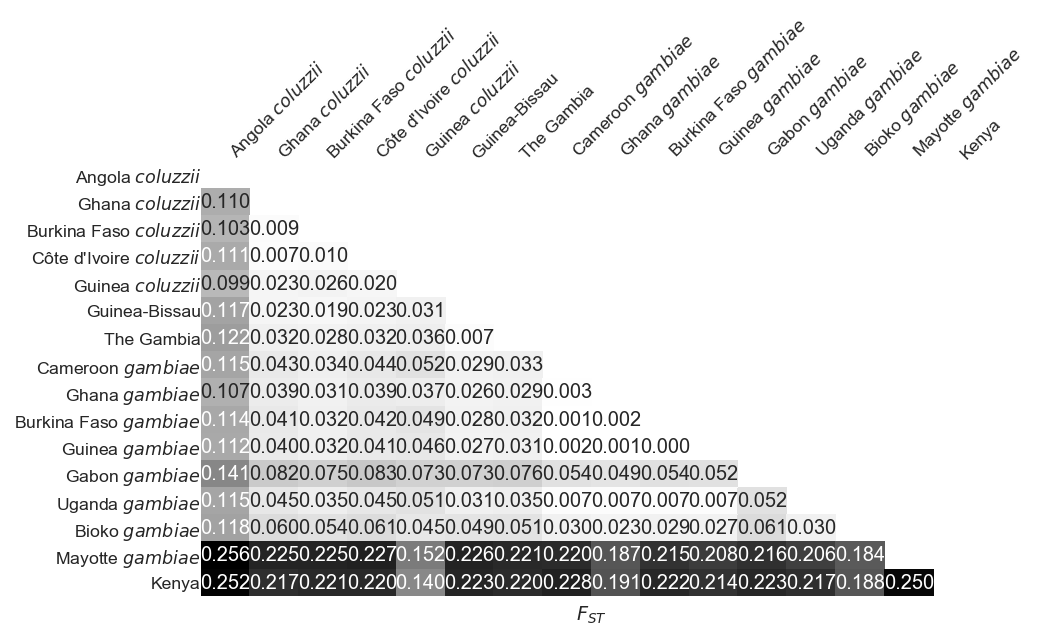

In [12]:
plot_pairwise_fst(pops=populations, regions=(region_3R_free, region_3L_free))

In [13]:
def plot_pairwise_fst_z(pops, regions, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.despine(ax=ax, top=False, bottom=True, offset=0)
        
    fst, se = compute_pairwise_fst(regions, blen=blen)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [populations.index(p) for p in pops]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.3f', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(fst)/np.array(se)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, vmax=1000000, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.1f', )
    
    xtl = [pop_labels[p] for p in pops]
    ytl = list(xtl)#[::-1]
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left')
    ax.set_yticklabels(ytl, rotation=0, ha='right')
    ax.tick_params(length=0, pad=3)
    ax.set_xlabel('$F_{ST}$')
    ax.set_ylabel('$Z$ score')
    ax.yaxis.set_label_position('right')
    return ax

In [17]:
def fig_pairwise_fst(pops, figsize=(7, 3), fn=None):
    fig, ax = plt.subplots(figsize=figsize)
    plot_pairwise_fst_z(pops=pops, regions=(region_3R_free, region_3L_free), ax=ax)
    #ax.text(-0.15, 1.2, '\\textbf{b}', ha='left', va='top', transform=ax.transAxes, fontsize=10)
    return fig

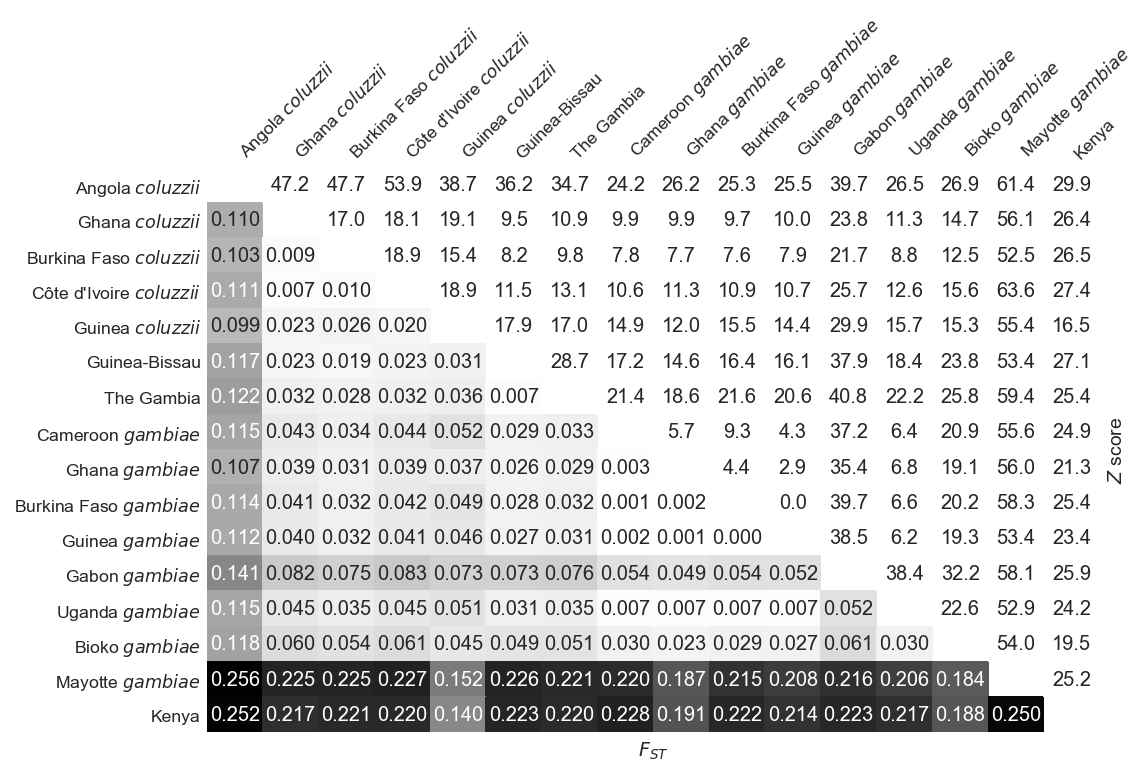

In [18]:
## fn_template = '../artwork/pairwise_fst.{size}.{dpi}.jpeg'
fig = fig_pairwise_fst(pops=populations, figsize=(8, 5.2))
fig.savefig('../artwork/pairwise_fst.svg', dpi=300, bbox_inches='tight')

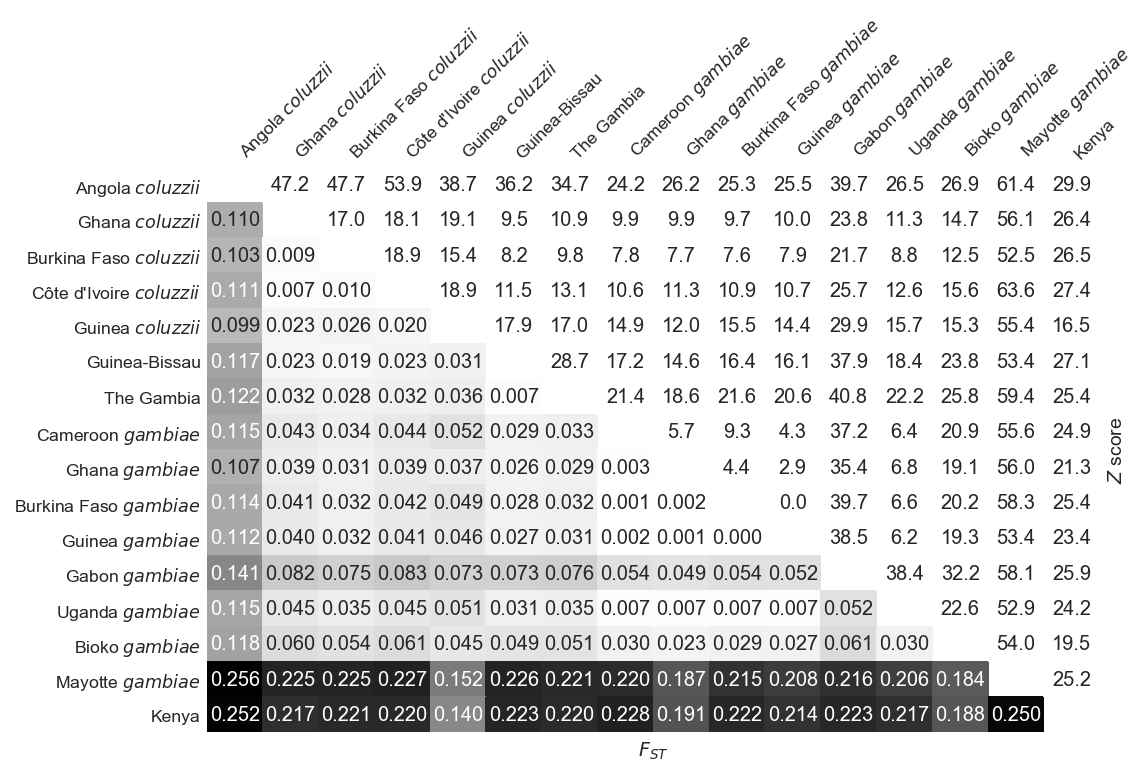

In [19]:
## fn_template = '../artwork/pairwise_fst.{size}.{dpi}.jpeg'
fig = fig_pairwise_fst(pops=populations, figsize=(8, 5.2))
fig.savefig('../artwork/pairwise_fst.jpeg', dpi=900, bbox_inches='tight', jpeg_quality=100)